# Spray Glider - Computing Autocorrelation functions for each transect 

**Purpose**: Code for computing the autocorrelation functions for scalar fields from each spray glider transects.

**Luke Colosi | lcolosi@ucsd.edu**

Force matplotlib plots to display directly within the output cell of the notebook: 

In [1]:
%matplotlib inline

Supress decrepation warnings

In [2]:
import warnings

# Suppress specific category of warnings (e.g., deprecation warnings)
warnings.filterwarnings("ignore")


Import python libraries


In [3]:
#--- Build-in Python Functions ---# 
import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset, num2date
from datetime import datetime
import sys
import os
from geopy.distance import geodesic
from scipy import stats

# Set path to access python functions
sys.path.append('/Users/lukecolosi/Desktop/projects/graduate_research/Gille_lab/AirSeaCoupling/tools/')

#--- Luke's Python Functions ---# 
import cartopy_figs as cart
from autocorr import compute_glider_autocorr, compute_glider_autocorr_interp

Set data analysis parameters

In [4]:
# Set processing parameters
option_plot          = 0      # Specifies if supplementary plots are plotted
option_var           = 'chla' # Specifies which variable will analyzed. Options include: temp, sal, doxy, chla, density   
option_depth_average = 0      # Specifies if the variable will be depth averaged or not
option_interp        = 1      # Specifies whether the transect will be interpolated or bin averaged onto a regular grid. If 0, data is bin averaged. If 1, data is interpolated.  

# Set time and space parameters
years_d      = ['2007','2008','2009','2010','2011','2012','2013','2014','2015','2016','2017','2018','2019','2020','2021','2022','2023']    # Specifies the year(s) to analyze
depth_lim    = 10                            # Specifies the bottom depth limit of the depth integration or the single depth for the data record. IMPORTANT: Make sure the single depth is an integer range from 10 to 500 meters in steps of 10 meters
L = 2.5 if option_interp == 0 else 1.5       # Spcifies the spatial interval for bin averaging  
on_lim       = -1000                         # Specifies the depth limit for the onshelf region 
off_lim      = -3150                         # Specifies the depth limit for the offshelf region 
trans_lim    = [on_lim + 100, off_lim - 300] # Specifies the depth limit for the transition region 
estimator    = 'biased'                      # Specifies the approach for estimating the autocorrelation function   

# Set path to project directory
PATH = "/Users/lukecolosi/Desktop/projects/graduate_research/Gille_lab/AirSeaCoupling"

# Set plotting parameters 
fontsize = 14

Load spray glider and intermediate data products (**NOTE**:  The intermediate data have the same profile coordinate as the spray glider data and have the same mask as the longitude and latitude from the spray glider data)

In [5]:
#--- Spray Glider Data ---# 
filename_sg = PATH + "/data/spray_gliders/CUGN_line_80.nc"
nc = Dataset(filename_sg, 'r')

# Extract data variables
profile = nc.variables['profile'][:]
depth   = nc.variables['depth'][:]

lon = nc.variables['lon'][:]
lat = nc.variables['lat'][:]
time =  num2date(nc.variables['time'][:], nc.variables['time'].units)

temperature = nc.variables['temperature'][:]
salinity = nc.variables['salinity'][:]
doxy = nc.variables['doxy'][:]
chla = nc.variables['chlorophyll_a'][:]

#--- Intermediate Data ---# 
filename_int = PATH + "/data/spray_gliders/CUGN_line_80_intermediate_data.nc"
nc = Dataset(filename_int, 'r')

# Extract data variables
dist           = nc.variables['DIST'][:]
Time           = nc.variables['TIME'][:]
water_depth    = nc.variables['WATER_DEPTH'][:]

SA             = nc.variables['ASal'][:]
CT             = nc.variables['CTemp'][:]
sigma0         = nc.variables['SIG'][:]

# Set the data to preform the scale analysis on
if option_var == 'temp':
    data = temperature
elif option_var == 'sal':
    data = salinity
elif option_var == 'doxy':
    data = doxy
elif option_var == 'chla':
    data = chla
elif option_var == 'density':
    data = sigma0

Now grab data from multiple years

In [6]:
# Grab data from a given depth or depth average
if option_depth_average == 0:
    data_dp = data[depth == depth_lim,:].T.squeeze()
else: 
    data_dp = np.ma.mean(data[(depth >= depth[0]) & (depth <= depth_lim),:].T,axis=1)

# Grab indices of masked elements 
time_mask = np.array(np.where(time.mask))   
lon_mask  = np.array(np.where(lon.mask))
lat_mask  = np.array(np.where(lat.mask))

# Check if the masked elements in time, lon, and lat 
if (time_mask == lon_mask).all() and (time_mask == lat_mask).all() and (lon_mask == lat_mask).all():

    # Combine masks from time and temperature 
    data_mask = np.logical_or(data_dp.mask,time.mask)

    # Mask temperature, time, lon, and lat on the new mask 
    data_m = np.ma.masked_where(data_mask,data_dp)
    time_m = np.ma.masked_where(data_mask,time)
    lon_m  = np.ma.masked_where(data_mask,lon)
    lat_m  = np.ma.masked_where(data_mask,lat)
    dist_m = np.ma.masked_where(data_mask,dist)
    water_depth_m = np.ma.masked_where(data_mask,water_depth)

    # Removed Masked values 
    data_m_cn = data_m.compressed()
    time_m_cn = time_m.compressed()
    lon_m_cn  = lon_m.compressed()
    lat_m_cn  = lat_m.compressed()
    dist_m_cn   = dist_m.compressed()
    water_depth_m_cn = water_depth_m.compressed()

    # Grab the years from the cleaned time array 
    years  = np.array([y.year for y in time_m_cn])

    # Initialize year array 
    data_t = []
    time_t = []
    lon_t = []
    lat_t = []
    dist_t = []
    water_depth_t = []

    # Loop through years 
    for iyear in range(0,len(years_d)):

        # Find indices for ith year
        year_idx = years == int(years_d[iyear]) 

        # Obtain time steps from ith year
        data_t.extend(data_m_cn[year_idx])
        time_t.extend(time_m_cn[year_idx])
        lon_t.extend(lon_m_cn[year_idx])
        lat_t.extend(lat_m_cn[year_idx])
        dist_t.extend(dist_m_cn[year_idx])
        water_depth_t.extend(water_depth_m_cn[year_idx])

# Convert variables to numpy arrays 
data_t        = np.ma.array(data_t)
time_t        = np.ma.array(time_t)
lon_t         = np.ma.array(lon_t)
lat_t         = np.ma.array(lat_t)
dist_t        = np.ma.array(dist_t)
water_depth_t = np.ma.array(water_depth_t)

# Convert cftime.DatetimeGregorian to Python datetime objects
time_dt = np.array([datetime(d.year, d.month, d.day, d.hour, d.minute, d.second) for d in time_t])

Plot the hovmoller diagram

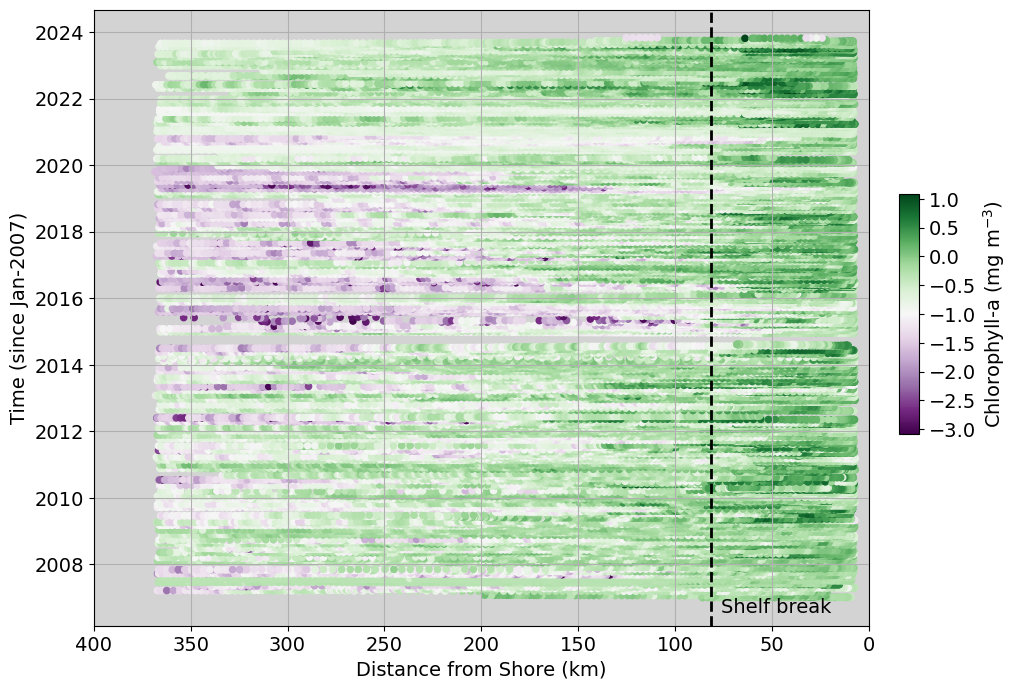

In [7]:
# Compute the distance to the shelf break from the shore (with Point Conception as the reference point) 
point_pc = (34.4488552,-120.457673)
point_sb = (34.23,-121.3)
distance_sb = geodesic(point_sb, point_pc).kilometers

# Specify colormap 
if option_var == 'temp':
    cmap = 'RdYlBu_r'
    cbar_label = r'Temperature ($^\circ$C)'
elif option_var == 'sal':
    cmap = 'BrBG_r'
    cbar_label = r'Salinity (psu)'
elif option_var == 'doxy':
    cmap = 'PRGn'
    cbar_label = r'Dissolved Oxygen (kg$^{-1}$)'
elif option_var == 'chla':
    cmap = 'PRGn'
    cbar_label = r'Chlorophyll-a (mg m$^{-3}$)'
elif option_var == 'density': 
    cmap = 'Spectral_r'
    cbar_label = r'$\sigma_0$ (kg m$^{-3}$)'

# Set the fontsize
plt.rcParams.update({'font.size': fontsize})

# Create figure
fig, axes = plt.subplots(1, 1, figsize=(10, 8))

# Plot trajectory through space time color coded by temperature
if option_var == 'chla':
    sc = axes.scatter(dist_t,time_dt,c=np.log10(data_t),cmap=cmap,s=20,marker='o')
else: 
    sc = axes.scatter(dist_t,time_dt,c=data_t,cmap=cmap,s=20,marker='o')

# Plot the distance of the shelf break from the shore
plt.axvline(x=distance_sb, color='k', linestyle='--', linewidth=2, label='Vertical Line')

# Set axis attributes
axes.set_xlabel(r"Distance from Shore (km)")
axes.set_ylabel(r"Time (since Jan-" + years_d[0] + ")")
axes.set_xlim(0, 400)
axes.grid()

# Add label text near the vertical line
plt.text(distance_sb-5,time_dt[0], r'Shelf break', color='k', fontsize=fontsize, ha='left',va='top',rotation=0)

# Reverse the direction of the x-axis 
plt.gca().invert_xaxis()

# Create colormbar
cax = plt.axes([0.93, 0.35, 0.02, 0.3])
cart.set_cbar(
    sc,
    cax,
    fig,
    orientation="vertical",
    extend="neither",
    cbar_label=cbar_label,
    nbins=10,
    fontsize=fontsize,
    cbar_ticks=[],
    task="regular",
)

# Set Colorbar limits 
#sc.set_clim(200, 300)

# Set the background color of the axes
axes.set_facecolor('lightgray')

# Display figure
plt.show()

# Save figure 
fig.savefig(fname = PATH + '/figs/spray_glider/Hovmoller_analysis/space_time_traj_' + option_var + '_'  + years_d[0] + '_to_' + years_d[-1] + '_depth_lim_' + str(depth_lim), bbox_inches = 'tight', dpi=300)

Spilt up the legs of the glider trajectory 

In [8]:
# Compute a moving mean filter (to smooth small fluctuations in the trajectory especially during turns)
window_size = 20 
dist_sm = np.convolve(dist_t, np.ones(window_size)/window_size, mode='same')

# Compute the distance between consecutive points traversed relative to shore (positive = moving off-shore, negative = moving on-shore) 
# and use prepend to ensure dist_diff is the same length as dist_t and dist_sm (first element is the difference between dist_sm[0] and dist_sm[0]) = 0
# which essentially means the glider starts from a stationary point)
dist_diff = np.diff(dist_sm, prepend = dist_sm[0]) 

# Determine direction by creating an array where points satisfying the off-shore condition are labeled as 1 and false elements are labeled as -1 
# (offshore = 1, onshore = -1)
direction = np.where(dist_diff > 0, 1, -1)

#--- Identify transition points ---#

# Get indicies where the direction changes 
transitions = np.where(np.diff(direction) != 0)[0] + 1  

# Initialize an array of segment labels (will later be assigned values based on offshore/onshore transitions)
segments = np.zeros_like(dist_sm, dtype=int) 

# Initialize segment label loop variable 
segment_id = 0

# Loop through segment identified by transition 
for i in range(len(transitions) - 1):

    # Assign segment labels 
    segments[transitions[i]:transitions[i + 1]] = segment_id

    # Increment segment label 
    segment_id += 1

#--- Remove short segments ---# 

# Count occurrences of each segment
segment_lengths = np.bincount(segments) 

# Set threshold for segment length (80 = only long transects, 50 = long and short transects)
min_segment_size = 93

# Identify valid transects labels 
valid_segments = np.where(segment_lengths >= min_segment_size)[0]

# Apply mask to remove short segments
mask = np.isin(segments, valid_segments)

#--- Remove Turning Periods after Segmentation ---#

# Compute speed using the raw distance (absolute change over time)
dx = np.abs(np.diff(dist_t, prepend=dist_t[0])) * 1000   # Units: meters
dt = np.diff(time_dt, prepend=time_dt[0]).astype('timedelta64[s]').astype(float)  # Units: seconds 
speed = (dx / dt)  # Units: m/s

# Define a threshold for slow movement (adjust as needed)
speed_threshold = 0.15

# Mask out points where speed is too low (turning points)
valid_speed_mask = speed > speed_threshold

# Define a minimum distance from shore threshold (adjust as needed)
min_distance_threshold = 10 

# Mask out points where distance from shore is too small
valid_distance_mask = dist_t >= min_distance_threshold

# Apply this mask **after segmentation** to remove turns while keeping valid transects
final_mask = mask & valid_speed_mask & valid_distance_mask  # Ensure both masks are applied correctly

#--- Filter out short segments ---# 
time_seg = time_dt[final_mask]
dist_seg = dist_t[final_mask]
data_seg = data_t[final_mask]
water_depth_seg = water_depth_t[final_mask]
segment_labels = segments[final_mask]
direction_seg = direction[final_mask]

Compute off-shore and on-shore autocorrelation functions for each transect

In [9]:
# Initialize counters
cn    = 0  # Counter for number of analyzable transects 
N     = 0  # Counter for total number of transects segmented
skips = 0  # Counter for number of transects skipped 

# Obtain unique segments 
unique_segments = np.unique(segment_labels)

# Initialize arrays 
L_on             = []
L_trans          = []
L_off            = []
meanTime           = []
autocorr_on        = []
autocorr_trans     = []
autocorr_off       = []
autocorr_on_n       = []
autocorr_trans_n   = []
autocorr_off_n     = []
autocov_on         = []
autocov_trans      = []
autocov_off        = []
autocov_full       = []
delta_on           = []
delta_trans        = []
delta_off          = []
delta_full         = []
delta_on_n         = []
delta_trans_n      = []
delta_off_n        = []

# Loop through segments 
for seg in unique_segments:

    # Increment and print Transect Number 
    N += 1 
    print('Transect number: ' + str(N))
    
    # Find indices of the ith segment
    seg_mask = segment_labels == seg

    # Obtain data for the ith segement 
    itime = time_seg[seg_mask]
    idist = dist_seg[seg_mask]
    idata = data_seg[seg_mask]
    iwater_depth = water_depth_seg[seg_mask]
    idirection = direction_seg[seg_mask]

    # Try statement to handle exceptions so that errors can be passed without crashing the program
    try: 

        # Check if that transect extends from the on region shore to off shore
        if (np.ma.max(water_depth_seg) >= on_lim + 400) & (np.ma.min(water_depth_seg) <= off_lim - 400):

            # Set the direction (Moving Onshore = -1, Moving Offshore = 1)
            idir = stats.mode(idirection, keepdims=True).mode[0]

            # Compute autocorrelation functions for each transect
            if option_interp == 1: 
                (
                    iautocorr_on, iautocorr_trans, iautocorr_off,              # Autocorrelation function normalized by zeroth lag 
                    iautocorr_on_n, iautocorr_trans_n, iautocorr_off_n,        # Autocorrelation function normalized by first lag 
                    iautocov_on, iautocov_trans, iautocov_off, iautocov_full,  # Autocovariance functon (for computing the spectrum)
                    iL_on, iL_trans, iL_off,                                   # Decorrelation scales (computed from the first lag normalization)
                    idist_on, idist_trans, idist_off, idist_full,              # Distance from shore for each region 
                    idist_scale_on_n, idist_scale_trans_n, idist_scale_off_n,  # Distance scale for each region 
                ) = compute_glider_autocorr_interp(
                    idist, idata, iwater_depth, L, 
                    on_lim, off_lim, trans_lim, idir, estimator, 
                    option_plot, []
                )
            else: 
                (
                    iautocorr_on, iautocorr_trans, iautocorr_off,              # Autocorrelation function normalized by zeroth lag 
                    iautocorr_on_n, iautocorr_trans_n, iautocorr_off_n,        # Autocorrelation function normalized by first lag 
                    iautocov_on, iautocov_trans, iautocov_off, iautocov_full,  # Autocovariance functon (for computing the spectrum)
                    iL_on, iL_trans, iL_off,                                   # Decorrelation scales (computed from the first lag normalization)
                    idist_on, idist_trans, idist_off, idist_full,              # Distance from shore for each region 
                    idist_scale_on_n, idist_scale_trans_n, idist_scale_off_n,  # Distance scale for each region 
                ) = compute_glider_autocorr(
                    idist, idata, iwater_depth, L, 
                    on_lim, off_lim, trans_lim, idir, estimator, 
                    option_plot, []
                )

            # Compute the distance scale for each region  
            dist_scale_on    = np.round(idist_on-idist_on[0],0)
            dist_scale_trans = np.round(idist_trans-idist_trans[0],0)
            dist_scale_off   = np.round(idist_off-idist_off[0],0)
            dist_scale_full  = np.round(idist_full-idist_full[0],0)

            # Round the distance scale for the first lag normalized autocorrelation function 
            dist_scale_on_n = np.round(dist_scale_on,0)
            dist_scale_trans_n = np.round(dist_scale_trans,0)
            dist_scale_off_n = np.round(dist_scale_off,0)

            # Append the autocorrelation function and distance scale to list 
            L_on.append(iL_on)
            L_trans.append(iL_trans)
            L_off.append(iL_off)
            autocorr_on.append(iautocorr_on)
            autocorr_trans.append(iautocorr_trans)
            autocorr_off.append(iautocorr_off)
            autocorr_on_n.append(iautocorr_on_n)
            autocorr_trans_n.append(iautocorr_trans_n)
            autocorr_off_n.append(iautocorr_off_n)
            autocov_on.append(iautocov_on)
            autocov_trans.append(iautocov_trans)
            autocov_off.append(iautocov_off)
            autocov_full.append(iautocov_full)
            delta_on.append(dist_scale_on)
            delta_trans.append(dist_scale_trans)
            delta_off.append(dist_scale_off)
            delta_full.append(dist_scale_full)
            delta_on_n.append(dist_scale_on_n)
            delta_trans_n.append(dist_scale_trans_n)
            delta_off_n.append(dist_scale_off_n)

            # Convert to timestamps (numerical values in seconds)
            timestamps = np.array([dt.timestamp() for dt in itime])

            # Compute mean timestamp for segment
            mean_timestamp = np.mean(timestamps)

            # Convert back to datetime
            meanTime.append(datetime.fromtimestamp(mean_timestamp)) 

            # Reinitialize counter
            cn += 1

    except Exception: 

        # Print warining message 
        print('Ran into error, skipping transect!')

        # Count the number of transect skips 
        skips += 1

# Print the number of skips 
print('Number of skipped transects: ' + str(skips) + ' of ' + str(N))

# Convert meanTime and decorrelation scales into a numpy array 
L_on    = np.array(L_on)
L_trans = np.array(L_trans)
L_off   = np.array(L_off)
meanTime  = np.array(meanTime)

# Convert the lists to a NumPy object array
autocorr_on     = np.array(autocorr_on, dtype=object)
autocorr_trans  = np.array(autocorr_trans, dtype=object)
autocorr_off    = np.array(autocorr_off, dtype=object)
autocorr_on_n     = np.array(autocorr_on_n, dtype=object)
autocorr_trans_n  = np.array(autocorr_trans_n, dtype=object)
autocorr_off_n    = np.array(autocorr_off_n, dtype=object)
autocov_on      = np.array(autocov_on, dtype=object)
autocov_trans   = np.array(autocov_trans, dtype=object)
autocov_off     = np.array(autocov_off, dtype=object)
autocov_full    = np.array(autocov_full, dtype=object)
delta_on        = np.array(delta_on, dtype=object)
delta_trans     = np.array(delta_trans, dtype=object)
delta_off       = np.array(delta_off, dtype=object)
delta_full      = np.array(delta_full, dtype=object)
delta_on_n        = np.array(delta_on, dtype=object)
delta_trans_n     = np.array(delta_trans, dtype=object)
delta_off_n       = np.array(delta_off, dtype=object)

Transect number: 1
Transect number: 2
Transect number: 3
Transect number: 4
Transect number: 5
Transect number: 6
Transect number: 7
Transect number: 8
Transect number: 9
Transect number: 10
Transect number: 11
Transect number: 12
Transect number: 13
Transect number: 14
Transect number: 15
Transect number: 16
Transect number: 17
Transect number: 18
Transect number: 19
Transect number: 20
Ran into error, skipping transect!
Transect number: 21
Transect number: 22
Transect number: 23
Transect number: 24
Transect number: 25
Transect number: 26
Transect number: 27
Transect number: 28
Transect number: 29
Transect number: 30
Transect number: 31
Transect number: 32
Transect number: 33
Transect number: 34
Transect number: 35
Ran into error, skipping transect!
Transect number: 36
Transect number: 37
Transect number: 38
Transect number: 39
Transect number: 40
Transect number: 41
Transect number: 42
Transect number: 43
Transect number: 44
Transect number: 45
Transect number: 46
Transect number: 47

Save intermediate data in a npz file for future use (A netcdf can not be used for saving object-type arrays)

In [10]:
# Check if file exists, then delete it
if option_interp == 0: 
    file_path = PATH + "/data/spray_gliders/CUGN_line_80_intermediate_data_autocorr_" + option_var  + "_depth_lim_" + str(depth_lim) + '_' + years_d[0] + '_to_' + years_d[-1] + '_bin_averaged' + ".npz"
else: 
    file_path = PATH + "/data/spray_gliders/CUGN_line_80_intermediate_data_autocorr_" + option_var  + "_depth_lim_" + str(depth_lim) + '_' + years_d[0] + '_to_' + years_d[-1] + '_interpolated' + ".npz"
if os.path.exists(file_path):
    os.remove(file_path)

# Set metadata
metadata = {
    'description': 'Unbiased autocovariance and' + estimator + ' autocorrelation functions for the ' + option_var + ' record for each transect from ' + years_d[0] + ' to ' + years_d[-1] + '. Additionally, the distance scale variable for each autocorrelation/autocovariance function is saved along side the computed decorrelation length scale.',
    'source': 'Spray glider gridded data',
    'units': 'km',
    'depth averaged': str(option_depth_average) + ' with depth lim: ' + str(depth_lim)
}

# Save data arrays and metadata to a .npz file
np.savez(file_path, 
        autocorr_on     = autocorr_on,
        autocorr_trans  = autocorr_trans,
        autocorr_off    = autocorr_off,
        autocorr_on_n     = autocorr_on_n,
        autocorr_trans_n  = autocorr_trans_n,
        autocorr_off_n    = autocorr_off_n,
        autocov_on      = autocov_on,
        autocov_trans   = autocov_trans,
        autocov_off     = autocov_off,
        autocov_full    = autocov_full,
        delta_on        = delta_on,
        delta_trans     = delta_trans,
        delta_off       = delta_off,
        delta_full      = delta_full,
        delta_on_n        = delta_on_n,
        delta_trans_n     = delta_trans_n,
        delta_off_n       = delta_off_n,
        L_on            = L_on, 
        L_trans         = L_trans, 
        L_off           = L_off, 
        time            = meanTime,
        metadata=metadata
        )

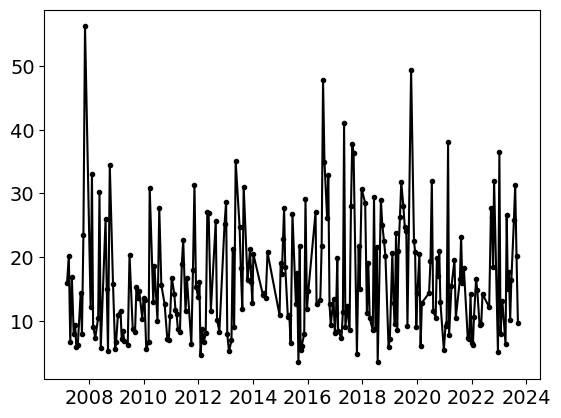

16.379466879998475
7.340261912688338
4.767469422581281


In [11]:
plt.plot(meanTime,L_off,'k.-')
#plt.ylim(-5,50)
plt.show()

print(np.mean(L_off))
print(np.mean(L_trans))
print(np.mean(L_on))